In [3]:
# !pip -q install transformers datasets evaluate accelerate
# !pip -q install -U transformers datasets accelerate evaluate
# import transformers, datasets, accelerate, evaluate, torch
# print("transformers:", transformers.__version__)
# !pip install -q evaluate

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 3.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.6/193.6 kB 9.6 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
bigframes 2.8.0 requires google-cloud-bigquery-storage<3.0.0,>=2.30.0, which is not installed.
cesium 0.12.4 requires numpy<3.0,>=2.0, but you have numpy 1.26.4 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cublas-cu12 12.5.3.2 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cuda-cupti-cu12==12.4.127; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cuda-cupti-cu12 12.5.82 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cuda-nvrtc-cu12==12.4.127; platform_system == "Linux" and platform_machine == 

In [4]:
import numpy as np
import pandas as pd 
from sklearn.model_selection import train_test_split
import os
import torch
from transformers import (AutoModelForSequenceClassification, TrainingArguments, Trainer, AutoTokenizer, EarlyStoppingCallback, set_seed)
import numpy as np
import evaluate
from datasets import Dataset, DatasetDict

In [5]:
SEED = 42 
set_seed(42)

In [6]:
df = pd.read_csv("/kaggle/input/imdb-dataset-of-50k-movie-reviews/IMDB Dataset.csv")
# Sample 10k rows, keeping sentiment distribution the same
df_sample = df.groupby('sentiment', group_keys=False).apply(
    lambda x: x.sample(n=5000, random_state=SEED)
)

# First split: Train vs Temp (80% train, 20% val and test)
train_df, temp_df = train_test_split(
    df_sample,
    test_size=0.2,
    random_state=SEED,
    stratify=df_sample['sentiment']
)

# Second split: Validation vs Test (10% both)
val_df, test_df = train_test_split(
    temp_df,
    test_size=0.5,
    random_state=SEED,
    stratify=temp_df['sentiment']
)

print(f"Train: {len(train_df)}, Val: {len(val_df)}, Test: {len(test_df)}")


Train: 8000, Val: 1000, Test: 1000


/tmp/ipykernel_36/3711564930.py:3: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_sample = df.groupby('sentiment', group_keys=False).apply(


In [7]:
# Features (X) and labels (Y)
X_train = train_df['review'].tolist()
Y_train = train_df['sentiment'].tolist()

X_val = val_df['review'].tolist()
Y_val = val_df['sentiment'].tolist()

X_test = test_df['review'].tolist()
Y_test = test_df['sentiment'].tolist()

print(len(X_train), len(X_val), len(X_test))
print(len(Y_train), len(Y_val), len(Y_test))

8000 1000 1000
8000 1000 1000


In [8]:
# Print first 3 from each split
print("X_train:", X_train[:1])
print("Y_train:", Y_train[:1])

print("\nX_val:", X_val[:1])
print("Y_val:", Y_val[:1])

print("\nX_test:", X_test[:1])
print("Y_test:", Y_test[:1])


X_train: ['A youth gets a bad hair day, goes out on a hill, and falls into where he can\'t escape. Then, he meets MR. ATLAS, a "mythological" dude from 2,000 years ago as his very best friend, and an Arnold Schwarzenegger look-and-sound-alike. His Herculean strength helps the boy out of danger, and later adjusts to modern life. So what\'s the big deal? This is the lousiest idea for a "family" outing! Either way, this one shouldn\'t have been attempted at all, really! Our fictional character of might and brawn is nothing more than a typical stranger who appears ordinary to the rest of the universe. To add to the blasphemy is the lack of anything new or appealing, and before you know it, there is some attempted violence that doesn\'t qualify this as "family" entertainment. The scene where Atlas complains of his undershorts is gaggling, though. Just spend a nice, quiet afternoon in the park for a change.']
Y_train: ['negative']

X_val: ['Cheezy? Yep. Poorly filmed? You betcha. Zero budget

In [9]:
# Convert labels to integer values
label_map = {"negative": 0, "positive": 1}

def prep(df):
    df = df.copy()
    df["label"] = df["sentiment"].map(label_map)
    df = df[["review", "label"]]
    # for tokenizer
    df.rename(columns={"review": "text"}, inplace=True)
    return df

ds = DatasetDict({
    "train": Dataset.from_pandas(prep(train_df), preserve_index=False),
    "validation": Dataset.from_pandas(prep(val_df), preserve_index=False),
    "test": Dataset.from_pandas(prep(test_df), preserve_index=False),
})
len(ds["train"]), len(ds["validation"]), len(ds["test"])


(8000, 1000, 1000)

In [10]:
MODEL_NAME = "distilbert-base-uncased"
# same tokenizer model was trained on
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

def tokenize(batch):
    return tokenizer(batch["text"], truncation=True, padding="max_length", max_length=256)

tokenized = ds.map(tokenize, batched=True, remove_columns=["text"])


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

Map:   0%|          | 0/8000 [00:00<?, ? examples/s]

Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

In [17]:
import inspect, transformers
from transformers import TrainingArguments

print("Transformers version:", transformers.__version__)
print("TrainingArguments comes from:", TrainingArguments.__module__)
print("Transformers file:", transformers.__file__)
print("Has 'evaluation_strategy'?:", "evaluation_strategy" in inspect.signature(TrainingArguments.__init__).parameters)

Transformers version: 4.52.4
TrainingArguments comes from: transformers.training_args
Transformers file: /usr/local/lib/python3.11/dist-packages/transformers/__init__.py
Has 'evaluation_strategy'?: False


In [26]:
# metrics (reuse your compute_metrics if you already defined it)
accuracy = evaluate.load("accuracy")
f1 = evaluate.load("f1")
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=-1)
    return {
        "accuracy": accuracy.compute(predictions=preds, references=labels)["accuracy"],
        "f1": f1.compute(predictions=preds, references=labels, average="weighted")["f1"]
    }

MODEL_NAME = "distilbert-base-uncased"

def freeze_all_but_last_k(model, k_last_layers: int):
    # Freeze everything
    for p in model.distilbert.parameters():
        p.requires_grad = False
    # Unfreeze last k transformer layers
    if k_last_layers > 0:
        layers = model.distilbert.transformer.layer
        for layer in layers[-k_last_layers:]:
            for p in layer.parameters():
                p.requires_grad = True
    # Always train the classifier head
    for p in model.pre_classifier.parameters(): p.requires_grad = True
    for p in model.classifier.parameters(): p.requires_grad = True
    for p in model.dropout.parameters(): p.requires_grad = True
    return model

# Hyperparameter grids
layer_choices   = [0, 1, 2]        # how many encoder layers to unfreeze
batch_choices   = [8, 16]             # per-device batch size
NUM_EPOCHS      = 5                   # set to 50 if you insist, but use early stopping!
BASE_LR         = 2e-5                # will decay via scheduler
# lr decaying linearly
SCHEDULER       = "linear"            # or "cosine"
WARMUP_RATIO    = 0.1                 # 10% warmup
TARGET_EFF_BS   = 32                  # use grad accumulation to simulate a larger batch

results = []

for k in layer_choices:
    for bsz in batch_choices:
        grad_accum = max(1, TARGET_EFF_BS // bsz)

        model = AutoModelForSequenceClassification.from_pretrained(MODEL_NAME, num_labels=2)
        model = freeze_all_but_last_k(model, k)

        args = TrainingArguments(
            output_dir=f"runs/k{k}_bs{bsz}",
            eval_strategy="epoch",
            save_strategy="epoch",
            logging_steps=100,
            learning_rate=BASE_LR,
            lr_scheduler_type=SCHEDULER,      # decays the LR over epochs
            warmup_ratio=WARMUP_RATIO,
            per_device_train_batch_size=bsz,
            per_device_eval_batch_size=32,
            gradient_accumulation_steps=grad_accum,
            num_train_epochs=NUM_EPOCHS,      # change to 50 if you really want (see note below)
            weight_decay=0.01,
            load_best_model_at_end=True,
            metric_for_best_model="accuracy",
            greater_is_better=True,
            fp16=torch.cuda.is_available(),
            report_to="none",
        )

        trainer = Trainer(
            model=model,
            args=args,
            train_dataset=tokenized["train"],
            eval_dataset=tokenized["validation"],
            tokenizer=tokenizer,
            compute_metrics=compute_metrics,
            callbacks=[EarlyStoppingCallback(early_stopping_patience=2, early_stopping_threshold=1e-4)]
        )

        trainer.train()
        val_metrics = trainer.evaluate(tokenized["validation"])
        results.append({
            "k_last_layers": k,
            "batch_size": bsz,
            "val_acc": val_metrics["eval_accuracy"],
            "val_f1": val_metrics["eval_f1"],
        })

results

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipykernel_36/136402727.py:69: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.673700,0.631863,0.794000,0.792986
2,0.587200,0.562895,0.786000,0.782205
3,0.546800,0.511446,0.829000,0.828986
4,0.511900,0.487724,0.837000,0.836980
5,0.503600,0.480268,0.842000,0.841876


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipykernel_36/136402727.py:69: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.672500,0.632788,0.796000,0.795052
2,0.584900,0.562745,0.786000,0.782321
3,0.546700,0.509820,0.832000,0.832000
4,0.512100,0.486784,0.839000,0.838999
5,0.503900,0.479177,0.842000,0.841876


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipykernel_36/136402727.py:69: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.499600,0.272608,0.889000,0.888991
2,0.301300,0.254771,0.898000,0.898000
3,0.278700,0.248969,0.900000,0.899974
4,0.270200,0.246496,0.905000,0.904989
5,0.249500,0.245357,0.904000,0.904000


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipykernel_36/136402727.py:69: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.500900,0.272736,0.892000,0.891984
2,0.303200,0.255930,0.901000,0.900998
3,0.281000,0.248490,0.904000,0.903997
4,0.269000,0.247281,0.908000,0.907987
5,0.249000,0.246003,0.908000,0.908000


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipykernel_36/136402727.py:69: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.358100,0.257688,0.897000,0.896888
2,0.269500,0.237263,0.913000,0.912998
3,0.240200,0.235747,0.917000,0.916999
4,0.220100,0.236744,0.917000,0.916999
5,0.193900,0.236082,0.919000,0.918996


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipykernel_36/136402727.py:69: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.363600,0.257376,0.901000,0.900928
2,0.269000,0.238682,0.915000,0.914999
3,0.246200,0.237795,0.914000,0.913988
4,0.221000,0.235912,0.921000,0.920999
5,0.191500,0.237023,0.921000,0.920998


[{'k_last_layers': 0,
  'batch_size': 8,
  'val_acc': 0.842,
  'val_f1': 0.8418760308081535},
 {'k_last_layers': 0,
  'batch_size': 16,
  'val_acc': 0.842,
  'val_f1': 0.8418760308081535},
 {'k_last_layers': 1,
  'batch_size': 8,
  'val_acc': 0.905,
  'val_f1': 0.9049885036089367},
 {'k_last_layers': 1,
  'batch_size': 16,
  'val_acc': 0.908,
  'val_f1': 0.9079867500920134},
 {'k_last_layers': 2,
  'batch_size': 8,
  'val_acc': 0.919,
  'val_f1': 0.9189960308055095},
 {'k_last_layers': 2,
  'batch_size': 16,
  'val_acc': 0.921,
  'val_f1': 0.9209992889936011}]

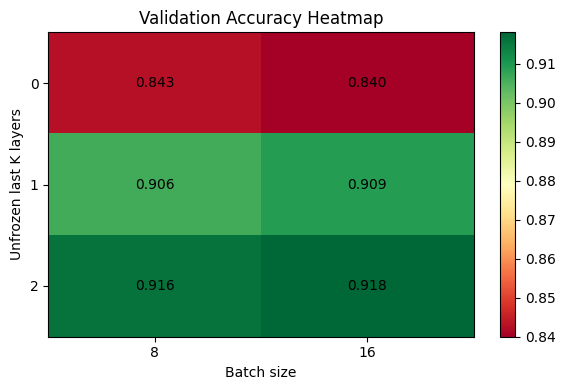

In [21]:
# Heatmap of validation accuracy (rows = K unfrozen layers, cols = batch size)
pivot = df.pivot_table(index="k_last_layers", columns="batch_size", values="val_acc", aggfunc="max")

plt.figure(figsize=(6,4))
im = plt.imshow(pivot.values, aspect="auto", cmap="RdYlGn")  # red → yellow → green
plt.xticks(ticks=np.arange(len(pivot.columns)), labels=pivot.columns)
plt.yticks(ticks=np.arange(len(pivot.index)), labels=pivot.index)
plt.xlabel("Batch size")
plt.ylabel("Unfrozen last K layers")
plt.title("Validation Accuracy Heatmap")

# annotate cells
for i in range(pivot.shape[0]):
    for j in range(pivot.shape[1]):
        val = pivot.values[i, j]
        if not np.isnan(val):
            plt.text(j, i, f"{val:.3f}", ha="center", va="center", color="black")

plt.colorbar(im)
plt.tight_layout()
plt.show()


In [23]:
# Last run was the best one so no need to retrain
test_metrics = trainer.evaluate(tokenized["test"])
print("Test accuracy:", test_metrics["eval_accuracy"])
print("Test F1:", test_metrics["eval_f1"])


Test accuracy: 0.887
Test F1: 0.8869944627286737


In [24]:
trainer.save_model("imdb_distilbert_model")
tokenizer.save_pretrained("imdb_distilbert_model")



('imdb_distilbert_model/tokenizer_config.json',
 'imdb_distilbert_model/special_tokens_map.json',
 'imdb_distilbert_model/vocab.txt',
 'imdb_distilbert_model/added_tokens.json',
 'imdb_distilbert_model/tokenizer.json')